<h3>Introduction</h3>
<p>The following is a machine learning and neural network project on predicting house sales around my hometown of Bowie, MD. The house data consists of house features and houses that were sold in the past 2 years from 2017 to present which were scraped off of Zillow. 
<p>Zillow obtains sale data from state tax records, which are all public, and this is used for our viewing. By scraping this information, we can use machine learning and neural networks to predict future sales of houses.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
import seaborn as sns
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics as metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

In [2]:
# import kerastuner

In [3]:
df = pd.read_csv("md_housing.csv")
df.head()

,id,Heating,Cooling,Basement,Flooring1,Flooring2,Architecture,ConstructMat1,ConstructMat2,RoofMat,...,ExteriorMat2,Address,StreetName,Region,Zipcode,YearBuilt,DateSold,PriceSqft,SalePrice,ListingURL
0,1,Forced air,Central,None basement,Carpet,Hardwood,Cape Cod,Shingle Siding,Shingle Siding,Shake/Shingle,...,Shingle,"12402 Keynote Ln, Bowie, MD 20715",Keynote Ln,Bowie,MD 20715,1963,19-Dec,207,290000,https://www.zillow.com/homedetails/12402-Keyno...
1,2,Forced air,Central,None basement,Carpet,Hardwood,Cape Cod,Other,Other,Asphalt,...,Other,"3013 Savoy Ln, Bowie, MD 20715",Savoy Ln,Bowie,MD 20715,1962,19-Dec,181,339900,https://www.zillow.com/homedetails/3013-Savoy-...
2,3,Forced air,Central,None,No Data,No Data,Ranch/Rambler,Aluminum Siding,Aluminum Siding,Shake/Shingle,...,Other,"12508 Kembridge Dr, Bowie, MD 20715",Kembridge Dr,Bowie,MD 20715,1963,19-Dec,191,355000,https://www.zillow.com/homedetails/12508-Kembr...
3,4,Forced air,Central,None,Carpet,Wood Floors,Colonial,Vinyl Siding,Vinyl Siding,Other,...,Vinyl,"2808 Baker Ln, Bowie, MD 20715",Baker Ln,Bowie,MD 20715,1962,19-Dec,183,380000,https://www.zillow.com/homedetails/2808-Baker-...
4,5,Forced air,Central,None,No Data,No Data,Cape Cod,No Data,No Data,Shake/Shingle,...,Other,"12819 Belhurst Ln, Bowie, MD 20715",Belhurst Ln,Bowie,MD 20715,1962,19-Dec,158,380250,https://www.zillow.com/homedetails/12819-Belhu...


Scraping house data on zillow created some duplicates, so we'll use Pandas' drop_duplicate() to remove them.

In [4]:
print("Amount of unique address:", len(df["Address"].unique()))
print("Amount of unique houses: ", df.shape[0])

df.drop_duplicates(subset="Address", keep="first", inplace=True)

Amount of unique address: 3529
Amount of unique houses:  3569


Determine the correlation between the different features with all of the houses.

(10.0, 0.0)

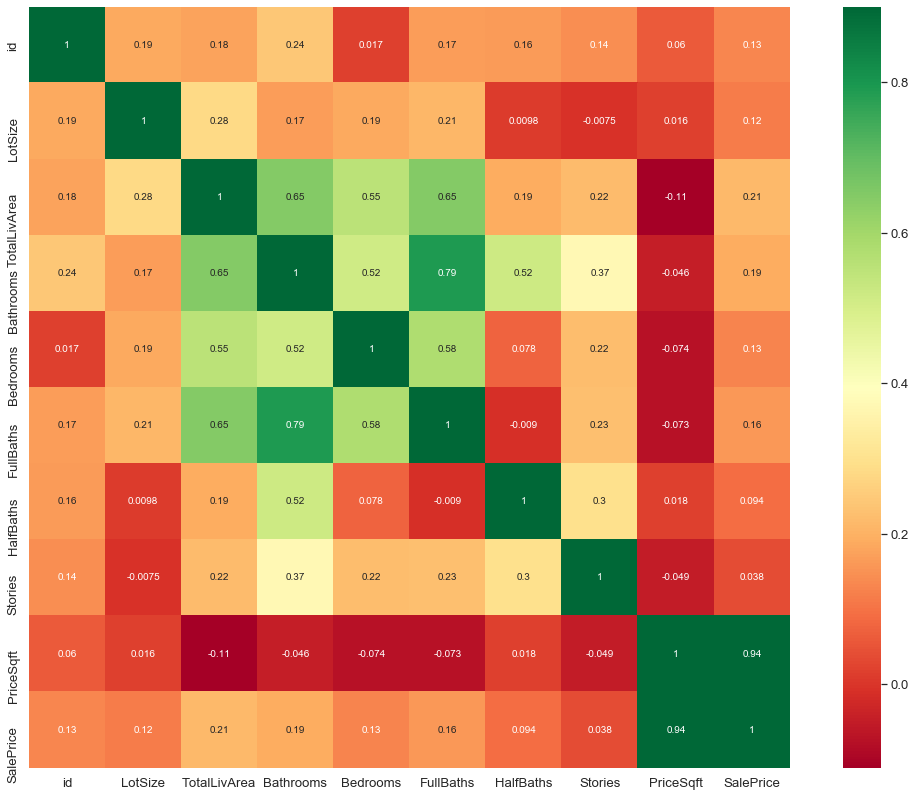

In [5]:
plt.figure(figsize=(19, 14))
sns.set(font_scale=1.2)
sns.heatmap(df.corr(), cbar=True, square=True, vmax=.9, annot_kws={'size': 10}, annot=True, cmap="RdYlGn")

# Fix a bug on the recent version of matplotlib where the bottom and top edges 
# of the seaborn heatmaps are cutoff, creating ugly, incomplete-looking edges.
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

Rename certain features to be more consistent from the messy scraped data and any outliers in the data. 
<p>Some houses were sold for \$2000 and over \$10,00,000. It could be real or a mess up in the state records inputted into Zillow.

In [6]:
df["Basement"].replace(["HasBasement:", "BasementType:", "None basement"], "None", inplace=True)
df["Basement"].replace("Basement:", "Finished basement", inplace=True)

# T-1-11 is a specific type of plywood siding used in these houses, many houses have these sidings 
# so we'll replace it with "Wood Siding."
df["ConstructMat1"].replace("T-1-11", "Wood Siding", inplace=True)
df["ConstructMat2"].replace("T-1-11", "Wood Siding", inplace=True)
df["ExteriorFeat1"].replace("View Type", "Water", inplace=True)

df.drop(["Address", "ListingURL"], axis=1, inplace=True)

df = df.drop(df[df["SalePrice"] > 3000000].index).reset_index(drop=True)
df = df.drop(df[df["SalePrice"] < 10000].index).reset_index(drop=True)

In [7]:
bowie = df[df["Region"] == "Bowie"]
bowie

,id,Heating,Cooling,Basement,Flooring1,Flooring2,Architecture,ConstructMat1,ConstructMat2,RoofMat,...,ExteriorFeat1,ExteriorMat1,ExteriorMat2,StreetName,Region,Zipcode,YearBuilt,DateSold,PriceSqft,SalePrice
0,1,Forced air,Central,None,Carpet,Hardwood,Cape Cod,Shingle Siding,Shingle Siding,Shake/Shingle,...,Patio,Shingle,Shingle,Keynote Ln,Bowie,MD 20715,1963,19-Dec,207,290000
1,2,Forced air,Central,None,Carpet,Hardwood,Cape Cod,Other,Other,Asphalt,...,Patio,Other,Other,Savoy Ln,Bowie,MD 20715,1962,19-Dec,181,339900
2,3,Forced air,Central,None,No Data,No Data,Ranch/Rambler,Aluminum Siding,Aluminum Siding,Shake/Shingle,...,Patio,Other,Other,Kembridge Dr,Bowie,MD 20715,1963,19-Dec,191,355000
3,4,Forced air,Central,None,Carpet,Wood Floors,Colonial,Vinyl Siding,Vinyl Siding,Other,...,Patio,Vinyl,Vinyl,Baker Ln,Bowie,MD 20715,1962,19-Dec,183,380000
4,5,Forced air,Central,None,No Data,No Data,Cape Cod,No Data,No Data,Shake/Shingle,...,Patio,Other,Other,Belhurst Ln,Bowie,MD 20715,1962,19-Dec,158,380250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,2198,Other,Central,Partially finished,Carpet,Hardwood,Colonial,No Data,No Data,Shake/Shingle,...,Yard,Brick,Vinyl,Maple Reach Ct,Bowie,MD 20720,2016,17-Jan,161,568880
2157,2199,Heat pump,No Data,Partially finished,No Data,No Data,No Data,No Data,No Data,Shake/Shingle,...,Patio,Other,Other,London Ln,Bowie,MD 20715,1986,17-Jan,192,238000
3497,3562,Forced air,Central,Partially finished,No Data,No Data,Colonial,No Data,No Data,Shake/Shingle,...,None,Other,Other,Issac Ducket Rd,Bowie,MD 20721,2015,19-Jun,150,725000
3498,3568,Forced air,Central,Partially finished,No Data,No Data,Colonial,No Data,No Data,Shake/Shingle,...,Patio,Brick,Brick,Elgin Cir,Bowie,MD 20721,2004,17-Dec,123,485000


In [8]:
print("Mean Sale Price for houses sold in Bowie:")
print("             *------------*")
print("             | ${:5.2f} |".format(bowie["SalePrice"].mean()))
print("             *------------*")

Mean Sale Price for houses sold in Bowie:
             *------------*
             | $370887.98 |
             *------------*


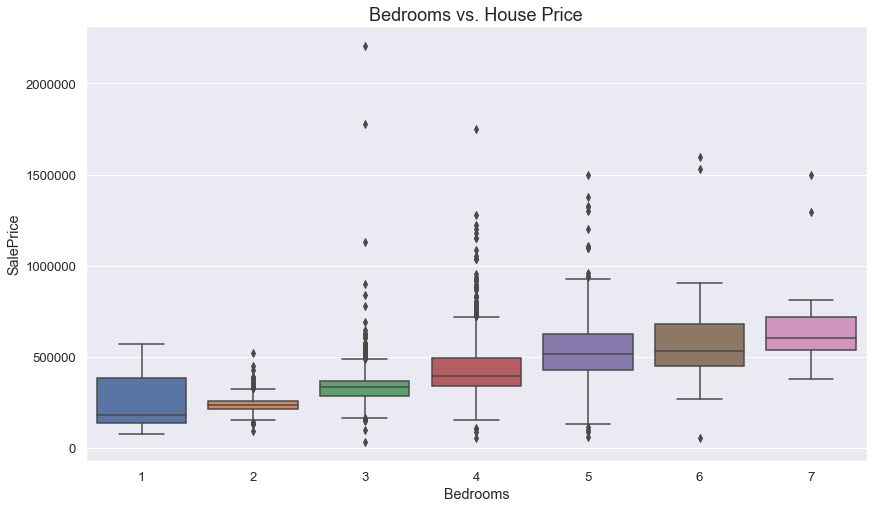

In [9]:
plt.figure(figsize=(14, 8))
plt.title("Bedrooms vs. House Price", fontsize=18)
sns.boxplot(x=df["Bedrooms"], y=df["SalePrice"])

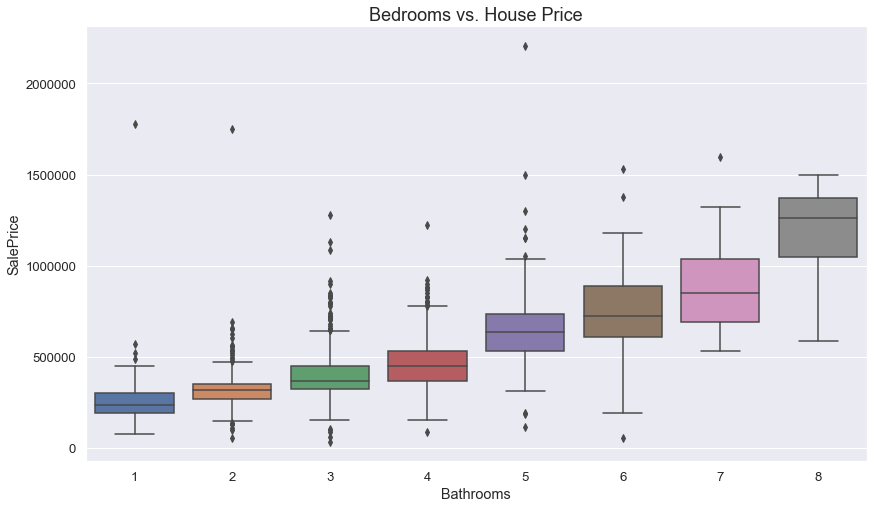

In [10]:
plt.figure(figsize=(14, 8))
plt.title("Bedrooms vs. House Price", fontsize=18)
sns.boxplot(x=df["Bathrooms"], y=df["SalePrice"])

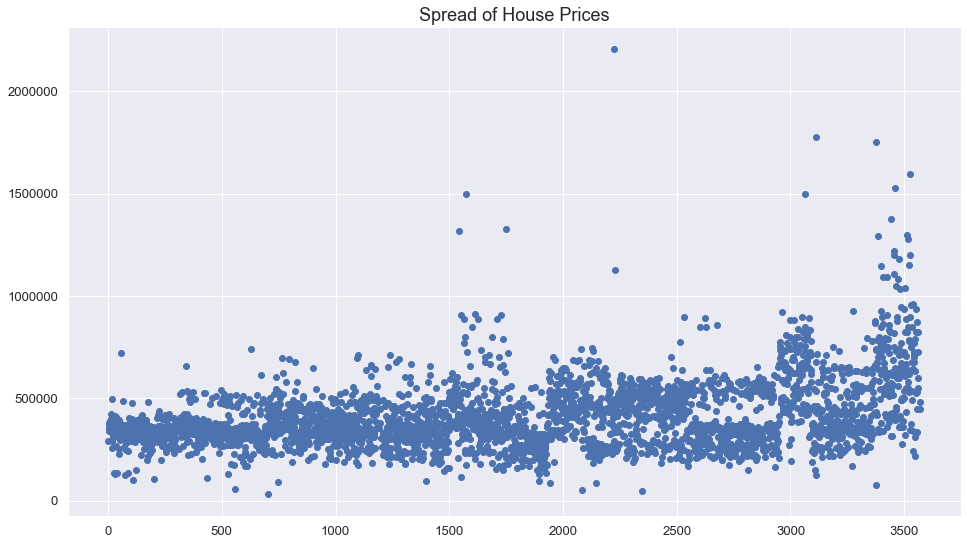

In [11]:
plt.figure(figsize=(16, 9))
plt.title("Spread of House Prices", fontsize=18)
plt.scatter(x=df["id"], y=df["SalePrice"])

<h3>Further preprocessing of data.</h3>

In [12]:
for c in df.columns:
    if df[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(df[c].values))
        df[c] = lbl.transform(list(df[c].values))

In [13]:
X = df.drop(["id", "SalePrice"], axis=1)
y = df["SalePrice"]

# Normalize the dataset to make calculations easier.
# Use normalization when the dataset consists of a large range of numbers.
X = (X - X.mean())/X.std()
X.head()

,Heating,Cooling,Basement,Flooring1,Flooring2,Architecture,ConstructMat1,ConstructMat2,RoofMat,LotSize,...,Stories,ExteriorFeat1,ExteriorMat1,ExteriorMat2,StreetName,Region,Zipcode,YearBuilt,DateSold,PriceSqft
0,-0.573156,-0.303122,-0.19498,-1.300670,-0.874804,-0.896131,0.589846,0.670461,0.602004,-0.244280,...,-0.008488,0.141936,0.502978,0.155290,-0.256770,-0.571195,-1.03423,-1.281204,0.761592,0.621134
1,-0.573156,-0.303122,-0.19498,-1.300670,-0.874804,-0.896131,0.426337,0.360657,-2.254577,-0.254278,...,-0.008488,0.141936,0.222790,-0.137079,0.986091,-0.571195,-1.03423,-1.339804,0.761592,0.109195
2,-0.573156,-0.303122,-0.19498,0.793903,0.289089,1.938658,-2.189802,-2.582486,0.602004,-0.200254,...,-1.088811,0.141936,0.222790,-0.137079,-0.292997,-0.571195,-1.03423,-1.281204,0.761592,0.306095
3,-0.573156,-0.303122,-0.19498,-1.300670,3.004838,-0.659898,1.407390,1.444973,0.030688,-0.154385,...,-0.008488,0.141936,1.343543,1.032398,-1.599951,-0.571195,-1.03423,-1.339804,0.761592,0.148575
4,-0.573156,-0.303122,-0.19498,0.793903,0.289089,-0.896131,0.262829,0.205754,0.602004,-0.044512,...,-0.008488,0.141936,0.222790,-0.137079,-1.521924,-0.571195,-1.03423,-1.339804,0.761592,-0.343674


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2800, 26)
X_test shape: (700, 26)
y_train shape: (2800,)
y_test shape: (700,)


<h3>Linear Regression</h3>

In [15]:
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(X_train, y_train)

y_linear_pred = linear_reg.predict(X_test)

linear_acc = linear_reg.score(X_test, y_test)
print(f"Intercept:     {linear_reg.intercept_}")
print(f"Coefficient Mean: {linear_reg.coef_.mean()}")
print(f"Accuracy:     {linear_acc}")

Intercept:     409011.78317983856
Coefficient Mean: 10111.968324683181
Accuracy:     0.8714628903242345


In [16]:
linear_df = pd.DataFrame({"Actual": y_test, "Predicted": y_linear_pred})
linear_df.head()

,Actual,Predicted
1650,799000,829702.090356
2456,450000,396592.019032
2232,210000,227200.652105
1945,310000,303573.465861
309,390000,341600.006182


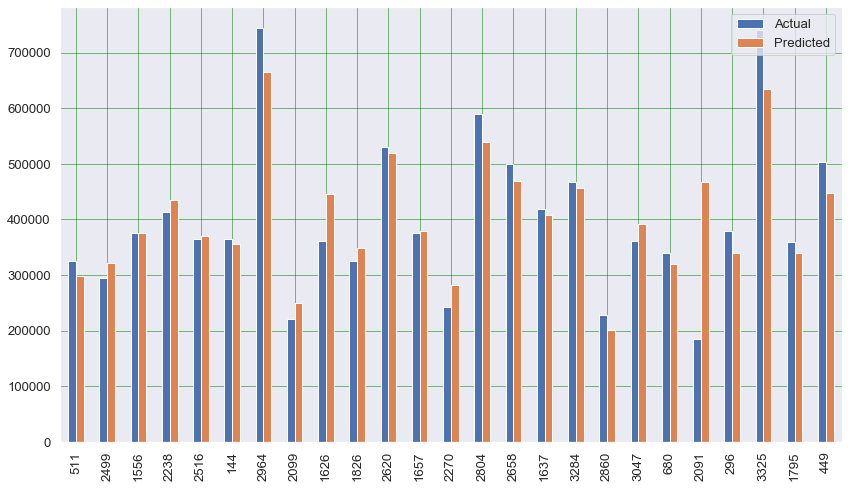

In [17]:
# Plot these predicted test values for 25 of them.
# Example inspired by 
# https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

df1 = linear_df.sample(25)
df1.plot(kind="bar", figsize=(14, 8))
plt.legend(loc='upper right')
plt.grid(which="major", linestyle="-", linewidth=0.5, color="green")
plt.grid(which="minor", linestyle=":", linewidth=0.5, color="blue")

In [18]:
print("Mean Absolute Error:     ${:5.2f}".format( metrics.mean_absolute_error(y_test, y_linear_pred) ))
print("Mean Squared Error:      ${:5.2f}".format( metrics.mean_squared_error(y_test, y_linear_pred)) )
print("Root Mean Squared Error: ${:5.2f}".format( np.sqrt(metrics.mean_squared_error(y_test, y_linear_pred))))

Mean Absolute Error:     $36695.08
Mean Squared Error:      $3409778550.01
Root Mean Squared Error: $58393.31


<h3>Random Forest Regressor</h3>

In [19]:
rf_params = {"min_samples_split": [4, 8, 12, 16], "n_estimators": [25, 75, 100]}

rf = RandomForestRegressor()
rf_grids = GridSearchCV(rf, rf_params)
rf_grids.fit(X_train, y_train)
print(rf_grids.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [20]:
rf_reg = RandomForestRegressor(min_samples_split=4, min_samples_leaf=1, n_estimators=75, n_jobs=-1, random_state=42)
rf_reg.fit(X_train, y_train)

y_rf_pred = rf_reg.predict(X_test)
rf_acc = rf_reg.score(X_test, y_test)
print(f"Accuracy: {rf_acc}")

Accuracy: 0.89125834018022


In [21]:
rf_df = pd.DataFrame({"Actual": y_test, "Predicted": y_rf_pred})
rf_df.head()

,Actual,Predicted
1650,799000,811181.346540
2456,450000,445295.702222
2232,210000,203470.814540
1945,310000,308849.596487
309,390000,390825.716190


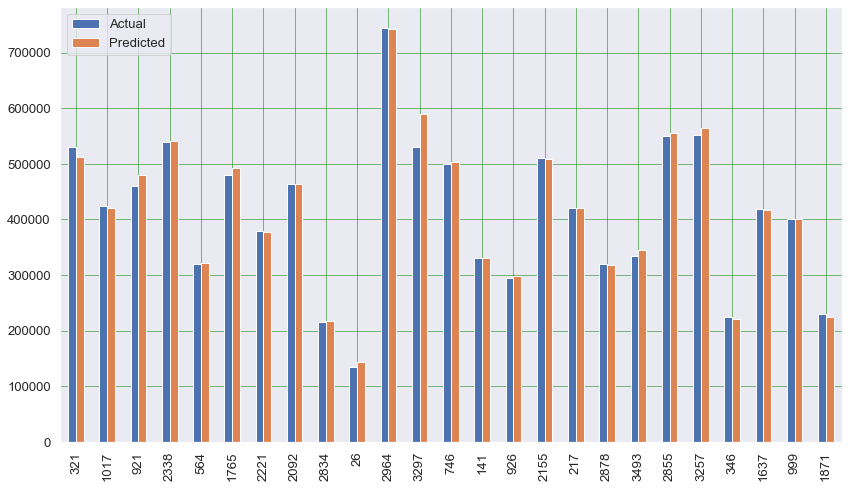

In [22]:
df2 = rf_df.sample(25)
df2.plot(kind="bar", figsize=(14, 8))
plt.legend(loc='upper left')
plt.grid(which="major", linestyle="-", linewidth=0.5, color="green")
plt.grid(which="minor", linestyle=":", linewidth=0.5, color="blue")

In [23]:
print("Mean Absolute Error:     ${:5.2f}".format( metrics.mean_absolute_error(y_test, y_rf_pred) ))
print("Mean Squared Error:      ${:5.2f}".format( metrics.mean_squared_error(y_test, y_rf_pred)) )
print("Root Mean Squared Error: ${:5.2f}".format( np.sqrt(metrics.mean_squared_error(y_test, y_rf_pred))))

Mean Absolute Error:     $11627.97
Mean Squared Error:      $2884653156.44
Root Mean Squared Error: $53708.97


<h3>Gradient Boost Regressor</h3>

In [24]:
gb_params = {"learning_rate": [0.001, 0.01, 0.1], "n_estimators": [25, 50, 75, 100], 
             "min_samples_split": [2, 4, 8], "random_state": [42]}

gb = GradientBoostingRegressor()
gb_grids = GridSearchCV(gb, gb_params)
gb_grids.fit(X_train, y_train)
print(gb_grids.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [25]:
gb_reg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, min_samples_split=8, random_state=42)
gb_reg.fit(X_train, y_train)

y_gb_pred = gb_reg.predict(X_test)
gb_acc = gb_reg.score(X_test, y_test)
print(f"Accuracy: {gb_acc}")

Accuracy: 0.9081055127028627


In [26]:
gb_df = pd.DataFrame({"Actual": y_test, "Predicted": y_gb_pred})
gb_df.head()

,Actual,Predicted
1650,799000,809319.218249
2456,450000,450239.713586
2232,210000,210761.220450
1945,310000,300139.081953
309,390000,374183.245599


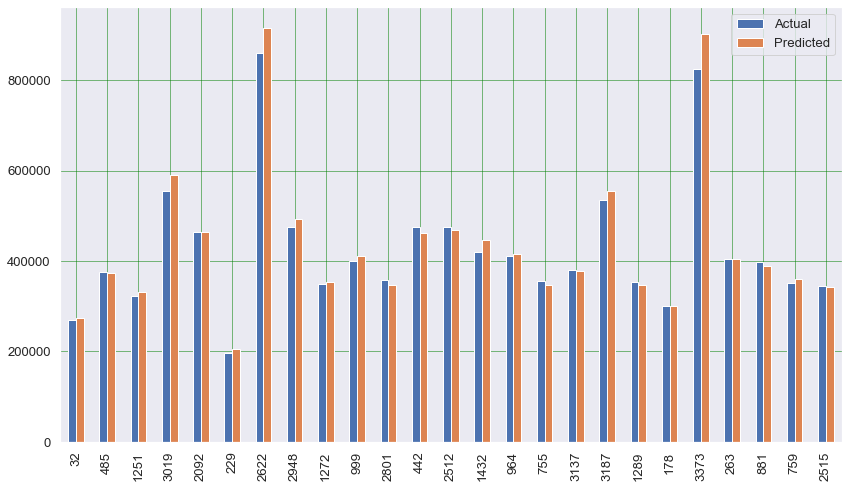

In [27]:
df3 = gb_df.sample(25)
df3.plot(kind="bar", figsize=(14, 8))
plt.legend(loc='upper right')
plt.grid(which="major", linestyle="-", linewidth=0.5, color="green")
plt.grid(which="minor", linestyle=":", linewidth=0.5, color="blue")

In [28]:
print("Mean Absolute Error:     ${:5.2f}".format( metrics.mean_absolute_error(y_test, y_gb_pred) ))
print("Mean Squared Error:      ${:5.2f}".format( metrics.mean_squared_error(y_test, y_gb_pred)) )
print("Root Mean Squared Error: ${:5.2f}".format( np.sqrt(metrics.mean_squared_error(y_test, y_gb_pred))))

Mean Absolute Error:     $12360.78
Mean Squared Error:      $2437738427.76
Root Mean Squared Error: $49373.46


<h3>Neural Network Building Time</h3>

In [29]:
def build_model():
    model = Sequential()

    # Input layer
    model.add(Dense(64, input_shape=[X_train.shape[1]]))
    model.add(Activation("relu"))

    # Hidden Layer 1
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(Dropout(0.05))

    # Hidden Layer 2
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(Dropout(0.10))

    # Hidden Layer 3
    model.add(Dense(64))
    model.add(Activation("relu"))
    model.add(Dropout(0.10))

    # Hidden Layer 4
    model.add(Dense(32))
    model.add(Activation("relu"))
    model.add(Dropout(0.025))

    # Hidden Layer 5
    model.add(Dense(32))
    model.add(Activation("relu"))
    model.add(Dropout(0.015))

    # Output layer
    model.add(Dense(1))
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])    
    
    return model

In [30]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1728      
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0

In [31]:
EPOCHS = 350

model_history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, batch_size=32, verbose=1)
#model.save("nn_house_model.h5")

Train on 2240 samples, validate on 560 samples
Epoch 1/350
2240/2240 [==============================] - 1s 481us/sample - loss: 190520238197.0286 - mae: 405910.7500 - mse: 190520229888.0000 - val_loss: 174814525615.5428 - val_mae: 388036.7812 - val_mse: 174814527488.0000
Epoch 2/350
2240/2240 [==============================] - 0s 122us/sample - loss: 85003734250.0571 - mae: 242612.0781 - mse: 85003739136.0000 - val_loss: 21461619916.8000 - val_mae: 110986.1797 - val_mse: 21461620736.0000
Epoch 3/350
2240/2240 [==============================] - 0s 112us/sample - loss: 17387984157.2571 - mae: 95134.6250 - mse: 17387986944.0000 - val_loss: 14068391467.8857 - val_mae: 87194.2031 - val_mse: 14068391936.0000
Epoch 4/350
2240/2240 [==============================] - 0s 110us/sample - loss: 14042517328.4571 - mae: 84206.0469 - mse: 14042516480.0000 - val_loss: 11674172196.5714 - val_mae: 78586.5703 - val_mse: 11674173440.0000
Epoch 5/350
2240/2240 [==============================] - 0s 110us/sam

Epoch 38/350
2240/2240 [==============================] - 0s 109us/sample - loss: 6958015199.0857 - mae: 52085.3711 - mse: 6958016000.0000 - val_loss: 5629658185.1429 - val_mae: 50437.3281 - val_mse: 5629658112.0000
Epoch 39/350
2240/2240 [==============================] - 0s 108us/sample - loss: 6797246679.7714 - mae: 51151.3359 - mse: 6797245952.0000 - val_loss: 5418837855.0857 - val_mae: 48864.6680 - val_mse: 5418838016.0000
Epoch 40/350
2240/2240 [==============================] - 0s 107us/sample - loss: 6187268525.7143 - mae: 50221.5664 - mse: 6187268096.0000 - val_loss: 5435368696.6857 - val_mae: 46023.7539 - val_mse: 5435368960.0000
Epoch 41/350
2240/2240 [==============================] - 0s 109us/sample - loss: 6131197072.4571 - mae: 49479.8086 - mse: 6131195904.0000 - val_loss: 5312486495.0857 - val_mae: 46657.6055 - val_mse: 5312486912.0000
Epoch 42/350
2240/2240 [==============================] - 0s 108us/sample - loss: 6794414438.4000 - mae: 51028.1758 - mse: 6794414080.00

Epoch 76/350
2240/2240 [==============================] - 0s 110us/sample - loss: 5954915975.3143 - mae: 47285.9258 - mse: 5954915328.0000 - val_loss: 5427301288.2286 - val_mae: 49675.9922 - val_mse: 5427301888.0000
Epoch 77/350
2240/2240 [==============================] - 0s 108us/sample - loss: 5947564138.0571 - mae: 48338.0547 - mse: 5947565056.0000 - val_loss: 6561020533.0286 - val_mae: 58830.6914 - val_mse: 6561020416.0000
Epoch 78/350
2240/2240 [==============================] - 0s 108us/sample - loss: 6589112859.4286 - mae: 49415.3125 - mse: 6589111808.0000 - val_loss: 5225297444.5714 - val_mae: 45290.0195 - val_mse: 5225297408.0000
Epoch 79/350
2240/2240 [==============================] - 0s 112us/sample - loss: 6451144678.4000 - mae: 48964.7969 - mse: 6451143680.0000 - val_loss: 7244606668.8000 - val_mae: 63927.3984 - val_mse: 7244608000.0000
Epoch 80/350
2240/2240 [==============================] - 0s 109us/sample - loss: 5820506122.9714 - mae: 47628.1680 - mse: 5820506112.00

Epoch 114/350
2240/2240 [==============================] - 0s 117us/sample - loss: 5172218870.8571 - mae: 45297.1055 - mse: 5172219904.0000 - val_loss: 4927801570.7429 - val_mae: 43233.9648 - val_mse: 4927801856.0000
Epoch 115/350
2240/2240 [==============================] - 0s 120us/sample - loss: 5950985939.2000 - mae: 46300.7461 - mse: 5950986240.0000 - val_loss: 6115262551.7714 - val_mae: 56550.1094 - val_mse: 6115262464.0000
Epoch 116/350
2240/2240 [==============================] - 0s 140us/sample - loss: 5584458058.9714 - mae: 44870.3789 - mse: 5584458240.0000 - val_loss: 5467739618.7429 - val_mae: 51282.6836 - val_mse: 5467740160.0000
Epoch 117/350
2240/2240 [==============================] - 0s 116us/sample - loss: 5877620306.2857 - mae: 45596.1250 - mse: 5877620224.0000 - val_loss: 4963680314.5143 - val_mae: 42674.8477 - val_mse: 4963680768.0000
Epoch 118/350
2240/2240 [==============================] - 0s 117us/sample - loss: 5581581738.0571 - mae: 45400.0312 - mse: 55815818

Epoch 152/350
2240/2240 [==============================] - 0s 114us/sample - loss: 4951540255.0857 - mae: 41409.3398 - mse: 4951541248.0000 - val_loss: 3802999690.9714 - val_mae: 37250.1641 - val_mse: 3802999552.0000
Epoch 153/350
2240/2240 [==============================] - 0s 117us/sample - loss: 4628665631.0857 - mae: 40429.1172 - mse: 4628665856.0000 - val_loss: 4172660158.1714 - val_mae: 43056.0078 - val_mse: 4172660224.0000
Epoch 154/350
2240/2240 [==============================] - 0s 114us/sample - loss: 4510451254.8571 - mae: 41300.7852 - mse: 4510450688.0000 - val_loss: 4208509447.3143 - val_mae: 43797.2266 - val_mse: 4208509440.0000
Epoch 155/350
2240/2240 [==============================] - 0s 113us/sample - loss: 4528870486.8571 - mae: 39723.9609 - mse: 4528870400.0000 - val_loss: 3815078400.0000 - val_mae: 36764.0156 - val_mse: 3815078656.0000
Epoch 156/350
2240/2240 [==============================] - 0s 110us/sample - loss: 4302290378.0571 - mae: 39881.2578 - mse: 43022909

Epoch 190/350
2240/2240 [==============================] - 0s 113us/sample - loss: 3163401749.0286 - mae: 34505.2812 - mse: 3163401728.0000 - val_loss: 2905599330.7429 - val_mae: 38190.7930 - val_mse: 2905599488.0000
Epoch 191/350
2240/2240 [==============================] - 0s 110us/sample - loss: 3219726757.4857 - mae: 34846.3711 - mse: 3219726848.0000 - val_loss: 2103018653.2571 - val_mae: 27396.1953 - val_mse: 2103018880.0000
Epoch 192/350
2240/2240 [==============================] - 0s 111us/sample - loss: 2764828830.1714 - mae: 33756.2500 - mse: 2764828416.0000 - val_loss: 3638867221.9429 - val_mae: 45759.5078 - val_mse: 3638866944.0000
Epoch 193/350
2240/2240 [==============================] - 0s 111us/sample - loss: 2869249666.7429 - mae: 33622.6602 - mse: 2869249280.0000 - val_loss: 2658319191.7714 - val_mae: 36112.5703 - val_mse: 2658319104.0000
Epoch 194/350
2240/2240 [==============================] - 0s 115us/sample - loss: 3076889571.6571 - mae: 34422.2539 - mse: 30768890

Epoch 228/350
2240/2240 [==============================] - 0s 112us/sample - loss: 2212133393.3714 - mae: 31148.9688 - mse: 2212133632.0000 - val_loss: 2472845524.1143 - val_mae: 38655.3438 - val_mse: 2472845824.0000
Epoch 229/350
2240/2240 [==============================] - 0s 112us/sample - loss: 2365395015.3143 - mae: 30781.8496 - mse: 2365394944.0000 - val_loss: 1673346439.3143 - val_mae: 28215.3711 - val_mse: 1673346560.0000
Epoch 230/350
2240/2240 [==============================] - 0s 123us/sample - loss: 2207454380.8000 - mae: 30165.5781 - mse: 2207453952.0000 - val_loss: 1478609802.9714 - val_mae: 24868.7871 - val_mse: 1478609792.0000
Epoch 231/350
2240/2240 [==============================] - 0s 118us/sample - loss: 2322089793.8286 - mae: 30620.8145 - mse: 2322089984.0000 - val_loss: 2047131596.8000 - val_mae: 33374.4883 - val_mse: 2047131648.0000
Epoch 232/350
2240/2240 [==============================] - 0s 111us/sample - loss: 2341521417.1429 - mae: 31696.5781 - mse: 23415214

Epoch 266/350
2240/2240 [==============================] - 0s 112us/sample - loss: 2008114387.2000 - mae: 29478.3574 - mse: 2008114560.0000 - val_loss: 2094201695.0857 - val_mae: 34443.5625 - val_mse: 2094201728.0000
Epoch 267/350
2240/2240 [==============================] - 0s 111us/sample - loss: 1827370317.7143 - mae: 29770.2383 - mse: 1827370240.0000 - val_loss: 3223031632.4571 - val_mae: 44814.6875 - val_mse: 3223031808.0000
Epoch 268/350
2240/2240 [==============================] - 0s 114us/sample - loss: 1888619675.4286 - mae: 29556.3379 - mse: 1888619264.0000 - val_loss: 2583656579.6571 - val_mae: 40465.8750 - val_mse: 2583657216.0000
Epoch 269/350
2240/2240 [==============================] - 0s 113us/sample - loss: 1848067791.5429 - mae: 29066.4941 - mse: 1848068096.0000 - val_loss: 4302548611.6571 - val_mae: 56766.6914 - val_mse: 4302547968.0000
Epoch 270/350
2240/2240 [==============================] - 0s 112us/sample - loss: 1841154277.4857 - mae: 28277.2930 - mse: 18411540

Epoch 304/350
2240/2240 [==============================] - 0s 114us/sample - loss: 1491940118.8571 - mae: 27017.4902 - mse: 1491940224.0000 - val_loss: 3642267465.1429 - val_mae: 49151.2383 - val_mse: 3642267392.0000
Epoch 305/350
2240/2240 [==============================] - 0s 114us/sample - loss: 1470425513.1429 - mae: 27761.2598 - mse: 1470425600.0000 - val_loss: 2248419313.3714 - val_mae: 37381.9180 - val_mse: 2248419328.0000
Epoch 306/350
2240/2240 [==============================] - 0s 115us/sample - loss: 1746608409.6000 - mae: 28622.0762 - mse: 1746608768.0000 - val_loss: 2150454743.7714 - val_mae: 36315.2891 - val_mse: 2150454784.0000
Epoch 307/350
2240/2240 [==============================] - 0s 115us/sample - loss: 1792780769.3714 - mae: 28876.2383 - mse: 1792780544.0000 - val_loss: 2227950880.9143 - val_mae: 35483.1875 - val_mse: 2227951104.0000
Epoch 308/350
2240/2240 [==============================] - 0s 114us/sample - loss: 1549992430.6286 - mae: 27329.4570 - mse: 15499924

Epoch 342/350
2240/2240 [==============================] - 0s 116us/sample - loss: 1521372630.8571 - mae: 26997.4883 - mse: 1521372544.0000 - val_loss: 2818917251.6571 - val_mae: 41799.3711 - val_mse: 2818917632.0000
Epoch 343/350
2240/2240 [==============================] - 0s 115us/sample - loss: 1334409280.0000 - mae: 26406.0215 - mse: 1334409088.0000 - val_loss: 3037652911.5429 - val_mae: 43445.8125 - val_mse: 3037652736.0000
Epoch 344/350
2240/2240 [==============================] - 0s 118us/sample - loss: 1409891214.6286 - mae: 26624.9629 - mse: 1409890944.0000 - val_loss: 2375212533.0286 - val_mae: 35647.3945 - val_mse: 2375212544.0000
Epoch 345/350
2240/2240 [==============================] - 0s 116us/sample - loss: 1382695946.9714 - mae: 26652.1855 - mse: 1382695552.0000 - val_loss: 2656994969.6000 - val_mae: 41111.5703 - val_mse: 2656995072.0000
Epoch 346/350
2240/2240 [==============================] - 0s 116us/sample - loss: 1315893429.0286 - mae: 26272.5605 - mse: 13158937

In [32]:
loss2, mae, mse = model.evaluate(X_test, y_test, verbose=2)
print("Testing set Mean Abs Error: ${:5.2f}".format(mae))

700/700 - 0s - loss: 2012046888.2286 - mae: 33280.5430 - mse: 2012046976.0000
Testing set Mean Abs Error: $33280.54


In [33]:
hist = pd.DataFrame(model_history.history)
hist['epoch'] = model_history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
345,1.315893e+09,26272.560547,1.315894e+09,2.111141e+09,33723.914062,2.111141e+09,345
346,1.390751e+09,26492.365234,1.390751e+09,3.002322e+09,43899.472656,3.002322e+09,346
347,1.324555e+09,26564.099609,1.324556e+09,1.888231e+09,31523.564453,1.888231e+09,347
348,1.399494e+09,27012.957031,1.399494e+09,3.632598e+09,49005.707031,3.632599e+09,348
349,1.351142e+09,26540.636719,1.351142e+09,2.065943e+09,33688.910156,2.065944e+09,349


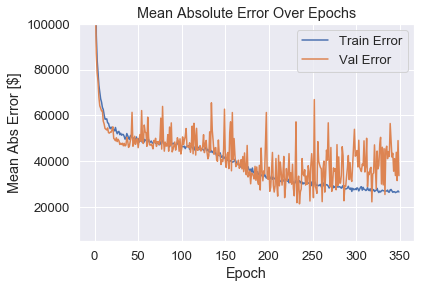

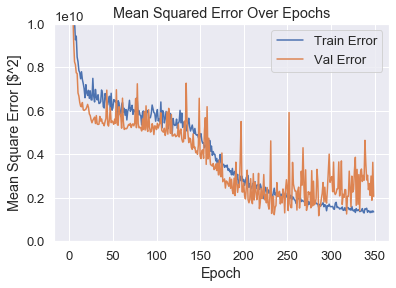

In [34]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [$]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.ylim([5000,100000])
    plt.title("Mean Absolute Error Over Epochs")
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$^2]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.ylim([0,1e10])
    plt.title("Mean Squared Error Over Epochs")
    plt.legend()
    plt.show()


plot_history(model_history)

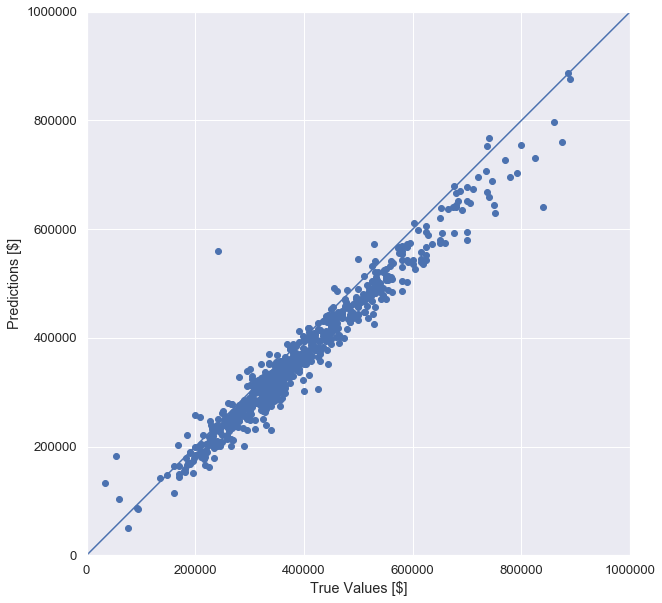

In [35]:
model_preds = model.predict(X_test).flatten()

plt.figure(figsize=(15, 10))
a = plt.axes(aspect='equal')
plt.scatter(y_test, model_preds)
plt.xlabel('True Values [$]')
plt.ylabel('Predictions [$]')
lims = [0, 1000000]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

<h3>Conclusion</h3>
<p>With a few outliers, 